In [1]:
# Import dependencies
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

from datetime import timedelta
from time import time

from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

warnings.filterwarnings(action='ignore')  # filter all warnings, in particular ConversionWarning (by numpy)

# Declare constants
AMPL_THRESH = 2  # Amplitude threshold
BANDS = 32  # Number of frequency bands
FREQ_THRESH = 512  # Frequency threshold
MU = 0.05  # Mean for adding noise from Gaussian distribution
N_FREQ = 12  # Numbers of frequencies
OVERLAP_SIZE = 20  # Number of overlapping rows for sliding window
SIGMA = 0.02  # Standard deviation for adding noise from Gaussian distribution
SLICE_SIZE = 40  # Number of rows which build one sample
TEST_BS = 32  # Batch size for testing
TRAIN_BS = 32  # Batch size for training


In [2]:
# Helper functions
def clean_data(data, n_freq=12,
               ampl_flag=True, ampl_thresh=2,
               freq_flag=True, freq_thresh=512):
    """Changes amplitudes and frequencies which are 
       more than amplitude/ frequency thresholds to thresholds.
    """
    
    data_copied = data[:, 1:].copy()  # do not include 1st column

    part1 = data_copied[:, list(range(0, n_freq))]  # amplitude
    part2 = data_copied[:, list(range(n_freq, 2*n_freq))]  # frequency
    part3 = data_copied[:, list(range(2*n_freq, 3*n_freq))]  # amplitude
    part4 = data_copied[:, list(range(3*n_freq, 4*n_freq))]  # frequency

    if ampl_flag:
        part1[part1 > ampl_thresh] = ampl_thresh
        part3[part3 > ampl_thresh] = ampl_thresh
    
    if freq_flag:
        part2[part2 > freq_thresh] = freq_flag
        part4[part4 > freq_thresh] = freq_flag
  
    return np.hstack((part1, part2, part3, part4))


def check_data_quality(data, n_freq=12, freq_thresh=512, ampl_thresh=2):
    """Show statistics for rows where 
       frequencies and amplitudes more than threshold.
    """
    
    data_ampl = data[:, [list(range(0, n_freq)) + list(range(2*n_freq, 3*n_freq))]]
    outliers = data_ampl[data_ampl > ampl_thresh]
    if len(outliers) > 0:
        print(f"Amplitude outliers (> {ampl_thresh}): {stats.describe(outliers)}")
    else:
        print("There is no amplitude outliers")
    
    data_freq = data[:, [list(range(n_freq, 2*n_freq)) + list(range(3*n_freq, 4*n_freq))]]
    outliers = data_freq[data_freq > freq_thresh]
    if len(outliers) > 0:
        print(f"Frequency outliers (> {freq_thresh}): {stats.describe(outliers)}")
    else:
        print("There is no frequency outliers")


def get_stats(data, n_freq=12, figsize=(10, 6)):
    """Plot histograms for frequencies and amplitudes."""
    
    fig, ax = plt.subplots(3, 2, figsize=figsize)
    
    frequency = data[:, [list(range(n_freq, 2*n_freq))]].flatten()
    print(f"Stats for frequency axis 1: {stats.describe(frequency)}")
    ax[0][0].hist(frequency, density=True)
    ax[0][0].set_title('Frequency axis 1')

    amplitude = data[:, [list(range(0, n_freq))]].flatten()
    print(f"Stats for amplitude axis 1: {stats.describe(amplitude)}")
    ax[1][0].hist(amplitude, density=True)
    ax[1][0].set_title('Amplitude axis 1')
      
    frequency = data[:, [list(range(3*n_freq, 4*n_freq))]].flatten()
    print(f"Stats for frequency axis 2: {stats.describe(frequency)}")
    ax[0][1].hist(frequency, density=True)
    ax[0][1].set_title('Frequency axis 2')

    amplitude = data[:, [list(range(2*n_freq, 3*n_freq))]].flatten()
    print(f"Stats for amplitude axis 2: {stats.describe(amplitude)}")
    ax[1][1].hist(amplitude, density=True)
    ax[1][1].set_title('Amplitude axis 2')
   
    freq_ampl = frequency * amplitude
    print(f"Stats for freq * ampl axis 1: {stats.describe(freq_ampl)}")
    ax[2][0].hist(freq_ampl, density=True)
    ax[2][0].set_title('Freq * ampl axis 1')    

    freq_ampl = frequency * amplitude
    print(f"Stats for freq * ampl axis 2: {stats.describe(freq_ampl)}")
    ax[2][1].hist(freq_ampl, density=True)
    ax[2][1].set_title('Freq_ampl axis 2')    
    
    fig.tight_layout()


def plot_single_row(data, row=0, n_freq=12, figsize=(10, 6)):
    """Plot single row from data."""
    
    amplitude1 = data[row][0:n_freq]
    frequency1 = data[row][n_freq:2*n_freq]
    
    amplitude2 = data[row][2*n_freq:3*n_freq]    
    frequency2 = data[row][3*n_freq:4*n_freq]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.stem(frequency1, amplitude1)
    ax1.set_title('Axis 1')
    ax1.set_xlabel('Frequency')
    ax1.set_ylabel('Amplitude')

    ax2.stem(frequency2, amplitude2)
    ax2.set_title('Axis 2')
    ax2.set_xlabel('Frequency')
    ax2.set_ylabel('Amplitude')
    
    fig.tight_layout()


def plot_comparison(data1, data2, figsize=(14, 6)): 
    """Plot 2 histograms with each other."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, sharey=True)
    ax1.hist(data1)
    ax2.hist(data2)
    fig.tight_layout()    


# Read and Clean Data
The data may have the following problem:
- Outliers by amplitudes and frequencies
- Number of columns more than 49

Input data has the format:

- 0th element - 12 - service information
- [1-13) - Amplitudes of the first axis
- [13-25) - Frequencies of the first axis
- [25-37) - Amplitudes of the second axis
- [37-49) - Frequencies of the second axis

Raw data example:<img src="./illustrations/raw_data_example.png" width="1300" height="900" align=left>

In [3]:
# Read data
print("Reading data...")
t1 = time()
DATA_PATH = r'C:\Users\se.vi.dmitriev\.IdeaIC2019.2\config\scratches\data_norm_06032020_output.txt'
raw_data = np.genfromtxt(fname=DATA_PATH, dtype=np.float64, delimiter=',', invalid_raise=False)
print(f"Finished reading data in {timedelta(seconds=time()-t1)}")

raw_data[0:1]  # Show some data for sense


Reading data...
Finished reading data in 0:00:28.279969


array([[12. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. , 25.6,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ]])

In [4]:
# Check quality of the raw data
print("Checking quality of the raw data...")
t1 = time()
check_data_quality(raw_data[:, 1:], n_freq=N_FREQ, freq_thresh=FREQ_THRESH, ampl_thresh=AMPL_THRESH)
print(f"Finished checking quality in {timedelta(seconds=time()-t1)}")

# Clean data
print("\nCleaning data...")
t1 = time()
data = clean_data(raw_data, n_freq=N_FREQ, freq_flag=True, freq_thresh=FREQ_THRESH, ampl_flag=True, ampl_thresh=AMPL_THRESH)
print(f"Finished cleaning data in {timedelta(seconds=time()-t1)}")

# Check quality of the cleaned data
print("\nChecking quality of the cleaned data...")
t1 = time()
check_data_quality(data, n_freq=N_FREQ, freq_thresh=FREQ_THRESH, ampl_thresh=AMPL_THRESH)
print(f"Finished checking quality in {timedelta(seconds=time()-t1)}")

data[0:1]  # Show some data for sense


Checking quality of the raw data...
Amplitude outliers (> 2): DescribeResult(nobs=6408, minmax=(2.000023, 8191.875), mean=280.8718206939919, variance=675095.4261890579, skewness=5.189883206763977, kurtosis=35.96794977716712)
Frequency outliers (> 512): DescribeResult(nobs=1173, minmax=(512.2, 6553.5), mean=1952.311338448423, variance=1722507.7148286677, skewness=1.3894776396434034, kurtosis=2.2361201259830876)
Finished checking quality in 0:00:00.512316

Cleaning data...
Finished cleaning data in 0:00:00.656999

Checking quality of the cleaned data...
There is no amplitude outliers
There is no frequency outliers
Finished checking quality in 0:00:00.134361


array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. , 25.6,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ]])

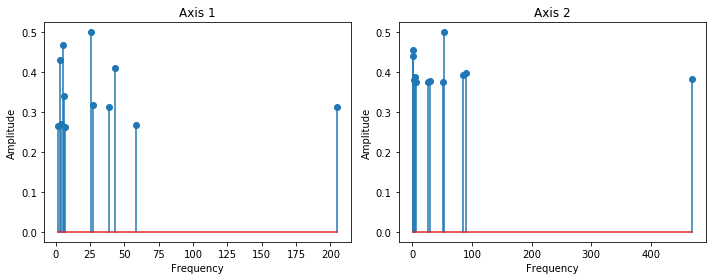

In [10]:
plot_single_row(data, row=50000, n_freq=N_FREQ, figsize=(10, 4))

Stats for frequency axis 1: DescribeResult(nobs=6270840, minmax=(0.0, 512.0), mean=92.90826578257457, variance=8959.530077266601, skewness=1.31308315956574, kurtosis=1.5365697918154044)
Stats for amplitude axis 1: DescribeResult(nobs=6270840, minmax=(0.0, 2.0), mean=0.41939569075916233, variance=0.016696579457844158, skewness=0.3323368059272499, kurtosis=14.352100798958645)
Stats for frequency axis 2: DescribeResult(nobs=6270840, minmax=(0.0, 512.0), mean=181.55060966313917, variance=33306.32419328725, skewness=0.5958305001032423, kurtosis=-1.3291951411019194)
Stats for amplitude axis 2: DescribeResult(nobs=6270840, minmax=(0.0, 2.0), mean=0.4334412258035173, variance=0.01870983082076092, skewness=0.5291200965647119, kurtosis=13.742665385115433)
Stats for freq * ampl axis 1: DescribeResult(nobs=6270840, minmax=(0.0, 1022.0), mean=84.71574754503658, variance=8557.719289859762, skewness=1.0849815529711953, kurtosis=1.353986876459004)
Stats for freq * ampl axis 2: DescribeResult(nobs=6270

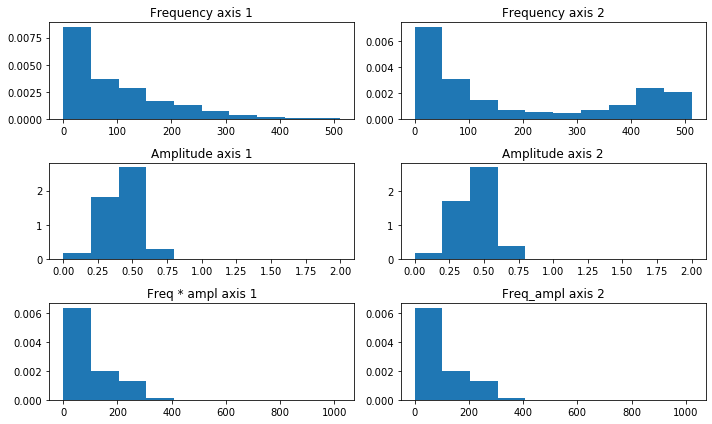

In [11]:
get_stats(data, n_freq=N_FREQ, figsize=(10, 6))

# Generate and Transform Data Samples
A data sample - data during 20s window, so 40 records in a raw data (each raw data is generated each 0.5s)

In [12]:
# Helper function
def generate_samples(data, slice_size=40, overlap_size=20,
                     transform=False, n_freq=12, low_freq=0, high_freq=512, num_bands=5,
                     data_augmentation=False, n_times=1, mu=0.05, sigma=0.02):
    """Returns data samples in format (N, slice_size, (num amplitudes and frequencies)), 
       where N - number of examples.
       If 'transform' is True then transform data in a form of table: rows - time, columns - frequency bands.
       if 'data_augmentation' is True then generate new data with noise.
    """
    
    output = []
    current_idx = 0
    while (current_idx + slice_size) <= len(data):
        output.append(data[current_idx: current_idx+slice_size])
        current_idx = current_idx + slice_size - overlap_size
    
    # Transform data in a form of table: rows - time, columns - frequency bands
    if transform:
        output_trans = []

        # Create bins for frequency bands
        bins_freq = np.linspace(low_freq, high_freq, num_bands+1)

        for i, sample in enumerate(output, 1):
            rows = []  # transformed raw records
            for record in sample:
                row = np.zeros(shape=num_bands*2)

                df_ax1 = pd.DataFrame({'ax1_ampl': record[0:n_freq],
                                       'ax1_freq': record[n_freq:2*n_freq]})

                df_ax2 = pd.DataFrame({'ax2_ampl': record[2*n_freq:3*n_freq],
                                       'ax2_freq': record[3*n_freq:4*n_freq]})

                df_ax1['band'] = np.digitize(df_ax1['ax1_freq'], bins_freq, right=True)
                df_ax2['band'] = np.digitize(df_ax2['ax2_freq'], bins_freq, right=True)

                df_ax1_grouped = df_ax1.groupby(by=['band']).mean()['ax1_ampl']
                df_ax2_grouped = df_ax2.groupby(by=['band']).mean()['ax2_ampl']

                for idx, value in df_ax1_grouped.items():
                    row[idx-1] = value

                for idx, value in df_ax2_grouped.items():
                    row[num_bands+idx-1] = value

                rows.append(row)
                
            output_trans.append(rows)
                                
            if i % 5000 == 0:
                print(f"{i} samples are ready")
            
        result_ini = np.array(output_trans)
        result = result_ini.copy()

        if data_augmentation:
            for i in range(n_times):
                addition = np.clip(result_ini + np.random.normal(mu, sigma, size=result_ini.shape), a_min=0, a_max=None)
                result = np.concatenate((result, addition), axis=0)

    else:
        result_ini = np.array(output)
        result = result_ini.copy()

        if data_augmentation:
            for i in range(n_times):
                addition = np.clip(result_ini + np.random.normal(mu, sigma, size=result_ini.shape), a_min=0, a_max=None)
                result = np.concatenate((result, addition), axis=0)

    return result


In [13]:
print("Generating samples...")
t1 = time()
X = generate_samples(data, slice_size=SLICE_SIZE, overlap_size=OVERLAP_SIZE,
                     transform=True, n_freq=N_FREQ, low_freq=0, high_freq=FREQ_THRESH, num_bands=BANDS,
                     data_augmentation=True, n_times=1, mu=MU, sigma=SIGMA)

print(f"Finished generating samples in {timedelta(seconds=time()-t1)}")

print(f"Shape: {X.shape}")

np.save(f"samples_{BANDS}bands_augment_data_06032020.npy", X)

X[0:1]  # Show some data for sense


Generating samples...
5000 samples are ready
10000 samples are ready
15000 samples are ready
20000 samples are ready
25000 samples are ready
Finished generating samples in 1:14:37.579154
Shape: (52254, 40, 64)


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [14]:
print("Loading saved samples...")
t1 = time()
X_load = np.load('samples_32bands_augment_data_06032020.npy')
print(f"Finished loading samples in {timedelta(seconds=time()-t1)}")

print(X_load.shape)
X_load[0:1]  # Show some data for sense


Loading saved samples...
Finished loading samples in 0:00:00.583474
(52254, 40, 64)


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

# Autoencoder

In [15]:
# Set seed for reproducible result
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_load_ = X_load[:, np.newaxis, :, :]

# Divide data: train, test
X_train, X_test = train_test_split(X_load_, shuffle=True, test_size=0.2)
X_train_t = torch.tensor(X_train, dtype=torch.float)
X_test_t = torch.tensor(X_test, dtype=torch.float)

# Prepare data aka DataLoader (pytorch)
train_ds = TensorDataset(X_train_t, X_train_t)
train_loader = DataLoader(train_ds, batch_size=TRAIN_BS, shuffle=True)

test_ds = TensorDataset(X_test_t, X_test_t)
test_loader = DataLoader(test_ds, batch_size=TEST_BS, shuffle=True)


In [16]:
# Create Network
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 32, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        # Decoder
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.up1 = nn.Upsample(scale_factor=2, mode="nearest")
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
        self.up2 = nn.Upsample(scale_factor=2, mode="nearest")
        self.conv5 = nn.Conv2d(64, 1, 3, padding=1)
    
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.up1(F.relu(self.conv3(x)))
        x = self.up2(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        return x

model = AutoEncoder()
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print(model)


AutoEncoder(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up1): Upsample(scale_factor=2.0, mode=nearest)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up2): Upsample(scale_factor=2.0, mode=nearest)
  (conv5): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [17]:
# Train network
print("Training neural network...")
t1 = time()
epochs = 50
min_loss = np.Inf
eps = 1e-4  # difference between current and previous losses
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 45], gamma=0.1)

for epoch in range(epochs):
    model.train()
    training_loss = 0
    for samples, target in train_loader:
        optimizer.zero_grad()    
        samples, target = samples.to(device), target.to(device)
        output = model.forward(samples)
        loss = criterion(output, target)
        training_loss += loss.item() * len(samples)
        loss.backward()
        optimizer.step()
    
    model.eval()
    testing_loss = 0
    with torch.no_grad():
        for samples, target in test_loader:
            samples, target = samples.to(device), target.to(device)
            output = model.forward(samples)
            loss = criterion(output, target)
            testing_loss += loss.item() * len(samples)
                
    training_loss = training_loss / len(train_ds)
    testing_loss = testing_loss / len(test_ds)
    print(f"Epoch {epoch + 1}, train loss: {training_loss:.7f}, "
          f"test loss: {testing_loss:.7f}")      
    
    if (min_loss - testing_loss) > eps:
        min_loss = testing_loss
        torch.save(model.state_dict(), "autoencoder_conv_augm_32bands_1channel_data_06032020.pt")
        print("The testing loss decreased --> Saved the model")
    
    scheduler.step()

print(f"Finished training neural network in {timedelta(seconds=time()-t1)}")


Training neural network...
Epoch 1, train loss: 0.0224308, test loss: 0.0186454
The testing loss decreased --> Saved the model
Epoch 2, train loss: 0.0171445, test loss: 0.0163412
The testing loss decreased --> Saved the model
Epoch 3, train loss: 0.0155160, test loss: 0.0150071
The testing loss decreased --> Saved the model
Epoch 4, train loss: 0.0143131, test loss: 0.0138942
The testing loss decreased --> Saved the model
Epoch 5, train loss: 0.0133785, test loss: 0.0130967
The testing loss decreased --> Saved the model
Epoch 6, train loss: 0.0127474, test loss: 0.0126905
The testing loss decreased --> Saved the model
Epoch 7, train loss: 0.0123436, test loss: 0.0122512
The testing loss decreased --> Saved the model
Epoch 8, train loss: 0.0120523, test loss: 0.0121027
The testing loss decreased --> Saved the model
Epoch 9, train loss: 0.0118343, test loss: 0.0118181
The testing loss decreased --> Saved the model
Epoch 10, train loss: 0.0116705, test loss: 0.0116448
The testing loss de

Building histograms...
Finished building histograms in 0:01:16.371205


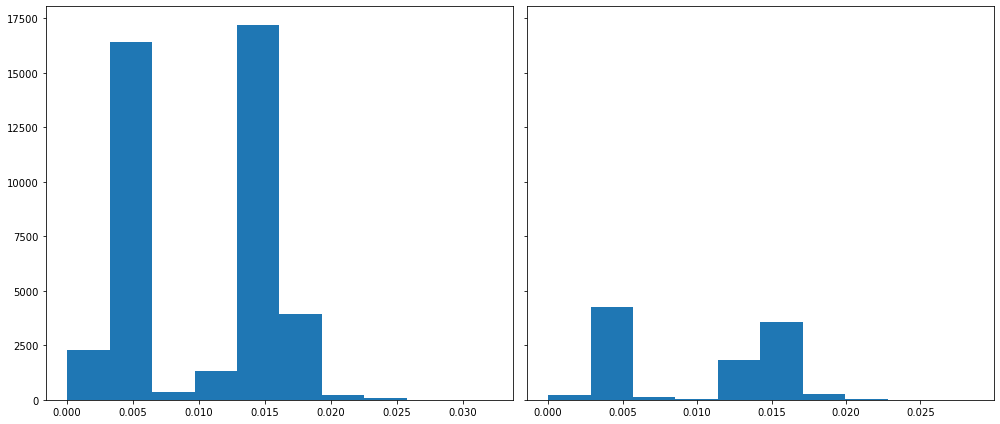

In [18]:
# Show losses
t1 = time()
print("Building histograms...")

with torch.no_grad():
    train_losses = []
    for i in range(len(X_train_t)):
        item = X_train_t[i:i+1]
        item = item.to(device=device)
        train_losses.append(criterion(model.forward(item), item).item())
        
    test_losses = []
    for i in range(len(X_test_t)):
        item = X_test_t[i:i+1]
        item = item.to(device=device)
        test_losses.append(criterion(model.forward(item), item).item())
    
plot_comparison(train_losses, test_losses)
print(f"Finished building histograms in {timedelta(seconds=time()-t1)}")


In [9]:
def transform_data(data, n_freq=12, low_freq=0, high_freq=512, num_bands=5):
    """Returns data into rows with frequency bands.
    """

    # Create bins for frequency bands
    bins_freq = np.linspace(low_freq, high_freq, num_bands+1)

    # Transform data in a form of table: rows - time, columns - frequency bands
    rows = []  # transformed raw records
    for record in data:
        row = np.zeros(shape=num_bands*2)

        df_ax1 = pd.DataFrame({'ax1_ampl': record[0:n_freq],
                                'ax1_freq': record[n_freq:2*n_freq]})

        df_ax2 = pd.DataFrame({'ax2_ampl': record[2*n_freq:3*n_freq],
                                'ax2_freq': record[3*n_freq:4*n_freq]})

        df_ax1['band'] = np.digitize(df_ax1['ax1_freq'], bins_freq, right=True)
        df_ax2['band'] = np.digitize(df_ax2['ax2_freq'], bins_freq, right=True)

        df_ax1_grouped = df_ax1.groupby(by=['band']).mean()['ax1_ampl']
        df_ax2_grouped = df_ax2.groupby(by=['band']).mean()['ax2_ampl']

        for idx, value in df_ax1_grouped.items():
            row[idx-1] = value

        for idx, value in df_ax2_grouped.items():
            row[num_bands+idx-1] = value

        rows.append(row)                        
        
    return np.array(rows)[np.newaxis, np.newaxis, :, :]


In [24]:
# Get result
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 32, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        # Decoder
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.up1 = nn.Upsample(scale_factor=2, mode="nearest")
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
        self.up2 = nn.Upsample(scale_factor=2, mode="nearest")
        self.conv5 = nn.Conv2d(64, 1, 3, padding=1)
    
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.up1(F.relu(self.conv3(x)))
        x = self.up2(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        return x

criterion = nn.MSELoss()
the_model = AutoEncoder()
the_model.load_state_dict(torch.load("autoencoder_conv_augm_32bands_1channel_data_06032020.pt"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
the_model.to(device=device)
the_model.eval()


flask_raw_data = raw_data[10000:10040].copy()
flask_data = clean_data(
    flask_raw_data, n_freq=N_FREQ, 
    freq_flag=True, freq_thresh=FREQ_THRESH, 
    ampl_flag=True, ampl_thresh=AMPL_THRESH
)
flask_x = transform_data(flask_data, n_freq=N_FREQ, low_freq=0, high_freq=FREQ_THRESH, num_bands=BANDS)
item = torch.tensor(flask_x, dtype=torch.float, device=device)
loss = criterion(the_model.forward(item), item).item()
print(f"Loss original data: {loss:.7f}")

flask_raw_data[0:20, 0:20] = 100
flask_data = clean_data(
    flask_raw_data, n_freq=N_FREQ, 
    freq_flag=True, freq_thresh=FREQ_THRESH, 
    ampl_flag=True, ampl_thresh=AMPL_THRESH
)
flask_x = transform_data(flask_data, n_freq=N_FREQ, low_freq=0, high_freq=FREQ_THRESH, num_bands=BANDS)
item = torch.tensor(flask_x, dtype=torch.float, device=device)
loss = criterion(the_model.forward(item), item).item()
print(f"Loss noise data: {loss:.7f}")


Loss original data: 0.0003788
Loss noise data: 0.0151393


In [27]:
# Test
import requests

url = "http://10.0.219.147:5000/predict"

payload = str(flask_raw_data.tolist())
headers = {
  'Content-Type': 'application/json'
}

response = requests.request("POST", url, headers=headers, data = payload)

print(response.text.encode('utf8'))

b'{"Loss":0.0151392612606287,"Normality":false}\n'


In [25]:
# Test
flask_raw_data = torch.tensor(flask_raw_data, dtype=torch.float, device=device)
str(flask_raw_data.tolist())

'[[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 16.0, 25.600000381469727, 8.199999809265137, 0.0, 0.20000000298023224, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.600000381469727, 0.0, 25.600000381469727, 26.399999618530273, 1.600000023841858, 0.0, 0.0, 128.0, 26.0], [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 6.400000095367432, 12.800000190734863, 0.0, 102.5999984741211, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.599999904632568, 0.800000011920929, 25.799999237060547, 3.200000047683716, 51.20000076293945, 6.400000095367432, 0.0, 412.79998779296875, 0.0, 3.200000047683716, 8.199999809265137], [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 7.0,